In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cuqi
from cuqi.model import Model #, LinearModel
from cuqi.geometry import MappedGeometry, Continuous1D, KLExpansion #, Geometry, Continuous
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.sampler import MH, NUTS
from scipy.linalg import lu_factor, lu_solve
import scipy as sp
import pickle

import arviz

from beam_model_1D import BeamModel1D

from plot_settings import define_plot_settings

define_plot_settings(18)

np.random.seed(4)
run_analysis = False

# 1D Beam thickness estimation

<img src="./figures/448603900_1013404393461142_1134514519153019174_n.jpg" width="1000">

The Bayesian inverse problem is to infer the second moment of inertia of the beam, $\mathbf{I}_z$, along the beam from measurements of the beam deflections, $\mathbf{u}$. This can be formulated as

$$ \mathbf{v} = G(\mathbf{I}_z) + G(\mathbf{I}_z) \times \bm{\epsilon} $$

where the forward model found by solving the finite element equations:

$$ G(\mathbf{I}_z) = \mathbf{K}(\mathbf{I}_z)^{-1} \mathbf{f} $$

**Note that the noise model is multiplicative!**

To represent the thickness as a continuous random function, the KL expansion is introduced as:

$$ \mathbf{X} = \mu_t + \sigma \sum_{i=1}^{N_{KL}} Z_i \sqrt{\lambda_i} \mathbf{e}_i $$

where the thickness can be extracted as $\mathbf{I}_z = \exp({\mathbf{X}})$ to avoid negative thicknesses.

This transforms the Bayesian inverse problem to instead being a problem of inferring the coefficients, $Z_i$, i.e.

$$ \mathbf{v} = G(\mathbf{I}_z(Z_i)) + G(\mathbf{I}_z(Z_i)) \times \bm{\epsilon} $$


The noise is assummed Gaussian

$$ \bm{\epsilon} \sim \mathcal{N}(0, \sigma_{obs}^2 \mathbf{I}) $$

The likelihood function is obtained from the forward model as

<!-- $$\pi(v_{obs}|Z_i) \sim \mathcal{N}(G(\mathbf{I}_z (Z_i), \sigma_{obs}^2 \mathbf{I})$$ -->

$$\pi(v_{obs}|Z_i) \sim \mathcal{N}(G(\mathbf{I}_z (Z_i), G(\mathbf{I}_z(Z_i))^2 \sigma_{obs}^2 \mathbf{I})$$

Set-up model in CUQI

In [17]:
# Data and initialization
IZ = lambda X: np.exp(X)            # Define mapping
L = 100                             # Domain length 
N_points = 99                       # Number of discretization points
nelx = N_points                     # No. of beam elements
N_KL = 10                           # Number of terms in KL expansion
grid = np.linspace(0,L,N_points)    # Discretization for domain

# Create 1D beam model
beam = BeamModel1D(nelx=nelx, L=L)
model_Beam = Model(forward=beam.forward, 
                   range_geometry=Continuous1D(grid=grid),
                   domain_geometry=MappedGeometry(KLExpansion(grid=grid,
                                                              num_modes=N_KL,
                                                              decay_rate=2),
                                                              map=IZ))

# Gaussian prior: thkVec -> test it on beam domain (on Zs in KL expansion)
sigma_pr = 20
prior = Gaussian(0, sigma_pr**2, geometry=model_Beam.domain_geometry, name='Iz')

# def create_matrix(n):
#     matrix = np.zeros((n, n))
#     for i in range(n):
#         for j in range(n):
#             matrix[i, j] = (1 - ( abs(i - j)/n )*np.max(n/4.-abs(i-j),0) )**2
#     return matrix
# cov = create_matrix(N_points)
# cov = sp.sparse.diags(np.array([0.1, 0.25, 1, 0.25, 0.1]), 
#                       np.array([-2, -1, 0, 1, 2]), shape=(N_points, N_points))

Generate true signal:

/home/andfr/miniconda3/envs/clean_cookie/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


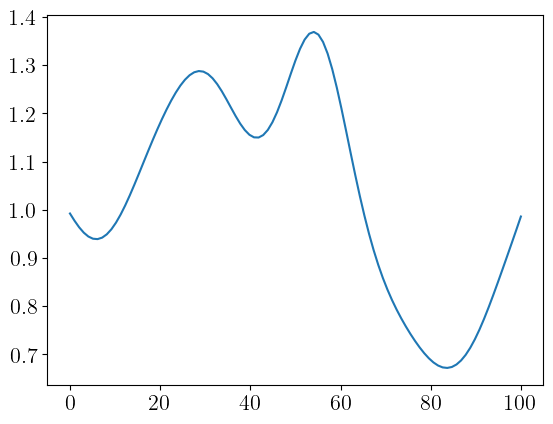

In [18]:
Zs_true = prior.sample(1)
Iz_true = Zs_true.funvals                # True beam thickness
v_true = beam.forward(Iz_true)           # True beam deflection

# Iz_true.plot()
plt.plot(grid, Iz_true)

Continuous1D(99,)
MappedGeometry(KLExpansion(10,))
1.878155739063378e-09


CUQI Model: MappedGeometry(KLExpansion(10,)) -> Continuous1D(99,).
    Forward parameters: ['Iz'].

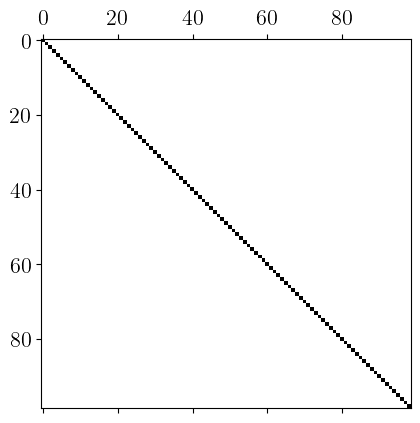

In [19]:
sigma_obs = 0.05

# Creating the covariance matrix
ell = 0.01*L
Gaussian_kernel = lambda xi1,xi2: \
    np.exp( -(xi1 - xi2)**2/(2*ell**2) ) # complete the lambda function for the Gaussian Kernel

cov = np.zeros([N_points, N_points])
for i in range(N_points):
    for j in range(N_points):
        cov[i,j] = Gaussian_kernel(grid[i], grid[j])

def cov_like(Iz):
    fx = model_Beam(Iz)
    cov_mat = sigma_obs**2*fx**2*np.identity(N_points) #*cov
    return cov_mat

# Gaussian Likelihood: v
likelihood = cuqi.distribution.Gaussian(mean=model_Beam, 
                                        cov=cov_like, 
                                        name='v')
print(model_Beam.range_geometry)
print(model_Beam.domain_geometry)

plt.spy(cov_like(Iz_true))
print(np.min(np.linalg.eigvals(cov_like(Iz_true))))
model_Beam

Create synthetic measurement data. This is acheived by obtaining first computing 'true' signal by sampling from the prior and running forward model. Then, the measurement data is obtained by adding noise to the 'true' signal.

In [20]:
epsilon = sp.stats.multivariate_normal.rvs(mean=np.zeros(N_points),
                                           cov=cov_like(Iz_true))
# plt.plot(epsilon)

Obtain measurement data

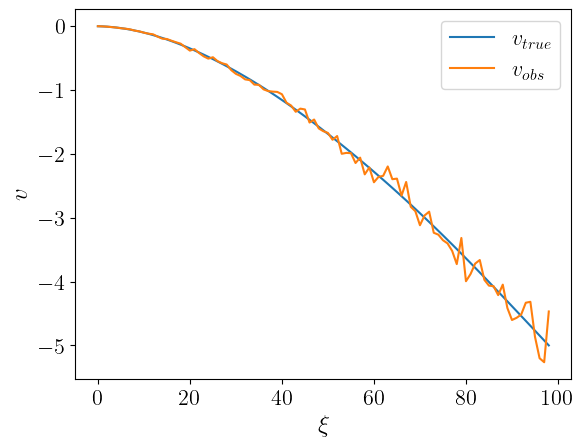

In [21]:
# Obtain measurement data by adding noise #TODO: Fix INVERSE CRIME
# v_obs = v_true + epsilon
v_obs = likelihood(Iz=Iz_true).sample(1)

# Plot true and measurement data together with likelihood function at t=t_true
plt.plot(v_true, label='$v_{true}$')
plt.plot(v_obs, label='$v_{obs}$')
# likelihood(Iz=Iz_true).sample(1).plot(label='$v_{like}(I_z=I_{z,{true}})$')
plt.xlabel('$\\xi$')
plt.ylabel('$v$')
plt.legend()

Define posterior model

In [38]:
joint = JointDistribution(likelihood,prior)
posterior = joint(v=v_obs)
print(posterior)
posterior.geometry

pickle_path = 'Zs_MAP.pickle'
if 0:
    Zs_MAP = cuqi.problem.BayesianProblem(likelihood, prior).set_data(v=v_obs).MAP()
    with open(pickle_path, 'wb') as handle:
        pickle.dump(Zs_MAP, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(pickle_path, 'rb') as pf:
        Zs_MAP = pickle.load(pf)

ValueError: Every density parameter must have a distribution (prior). Missing prior for ['Iz'].

Sample using the Metropolis-Hastings sampler

In [37]:
np.random.seed(10)
pickle_path = 'samples_MH.pickle'
if 1:
    Ns = 1000 #int(50e3)
    Z0 = Zs_MAP.to_numpy()
    sampler_MH = MH(posterior, x0=Z0, scale=1)
    samples_MH = sampler_MH.sample(Ns)

    # samples_MH.pickle()
    # res = {}
    # res['samples'] = samples_MH.samples
    # res['samples_funvals'] = samples_MH.funvals.samples
    # with open(pickle_path, 'wb') as handle:
    #     pickle.dump(sampler_MH, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    pass
    # with open(pickle_path, 'rb') as pf:
    #     res = pickle.load(pf)
    # samples_MH_samples = res['samples']
    # samples_MH_samples_funvals = res['samples_funvals']

TypeError: The attribute 'geometry' should be of type 'int' or 'cuqi.geometry.Geometry', or None.

Sample using the No-U-turn sampler (NUTS)

In [27]:
if 0:
    Ns = 5
    posterior.enable_FD()
    sampler_NUTS = NUTS(posterior, x0=Zs_MAP.to_numpy())
    samples_NUTS = sampler_NUTS.sample(Ns, Nb=1)

Compute effective sample sizes

In [28]:
print(samples_MH.compute_ess())
# print(samples_NUTS.compute_ess())

[5.07991301 3.78511759 1.5827905  1.61971967 1.93961677 5.32697312
 1.42251519 1.93021462 1.59529026 2.9500653 ]


Plot credible intervals

(0.0, 2.0)

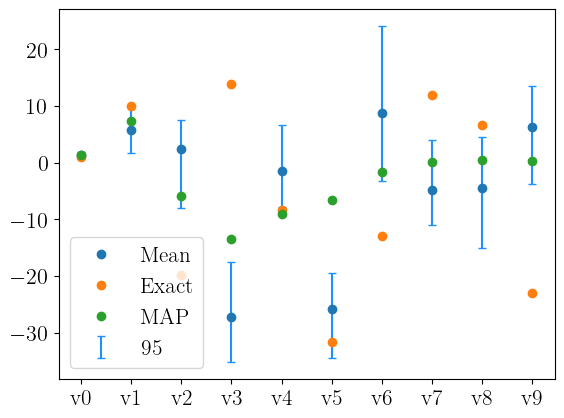

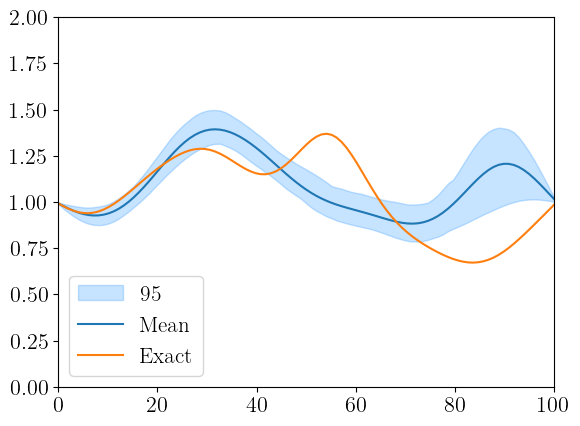

In [30]:
Nb = 100 #int(10e3)
Nt = int(5)
bt_samples_MH = samples_MH.burnthin(Nb, Nt)

bt_samples_MH.plot_ci(plot_par=True, exact=Zs_true)
# samples_NUTS.plot_ci(plot_par=True,exact=Zs_true)
plt.plot(Zs_MAP, 'o', label='MAP')

plt.legend()

plt.figure();
bt_samples_MH.funvals.plot_ci(plot_par=False, exact=Iz_true);
# plt.figure();

bt_samples = samples_MH.funvals.samples.T

plt.xlim([0, 100])
plt.ylim([0, 2])
# arviz.plot_hdi(grid, samples, hdi_prob=0.95)
# samples_NUTS.plot_ci(plot_par=False,exact=Zs_true)

# lower, upper = np.percentile(samples, [2.5, 97.5], axis=0)
# plt.fill_between(grid,
#                 lower,
#                 upper,
#                 color='red',
#                 label=r'95\% CI',
#                 alpha=0.25)

Plot trace for a specific variable

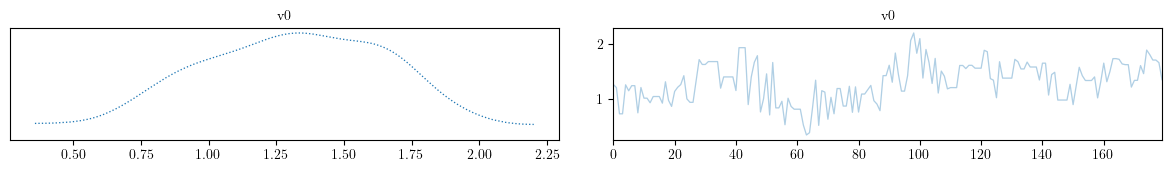

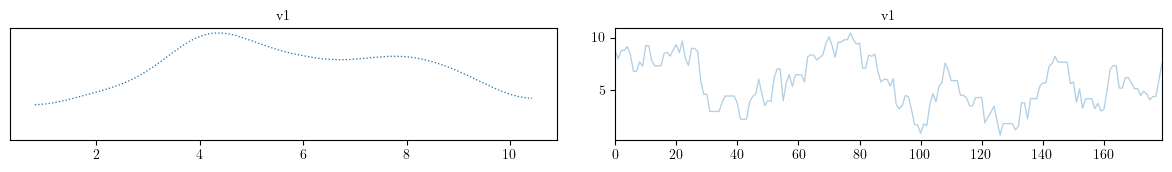

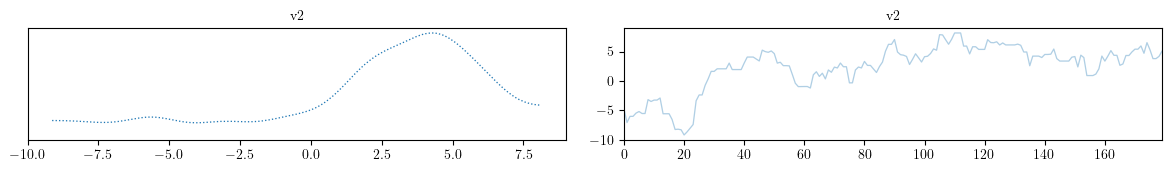

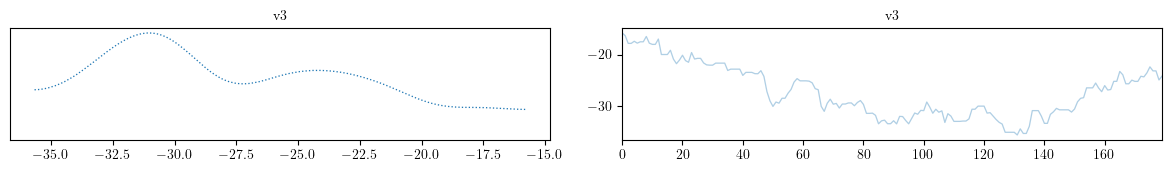

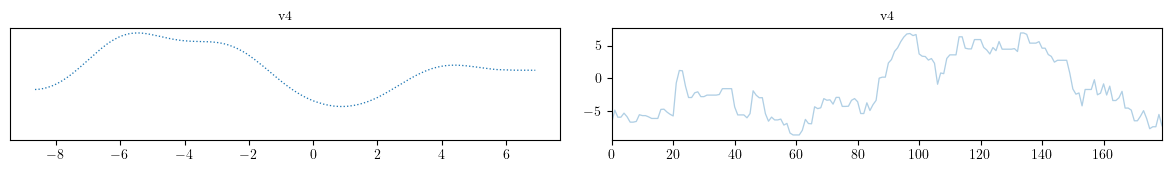

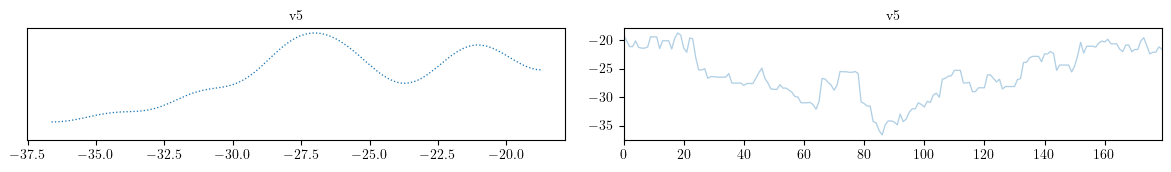

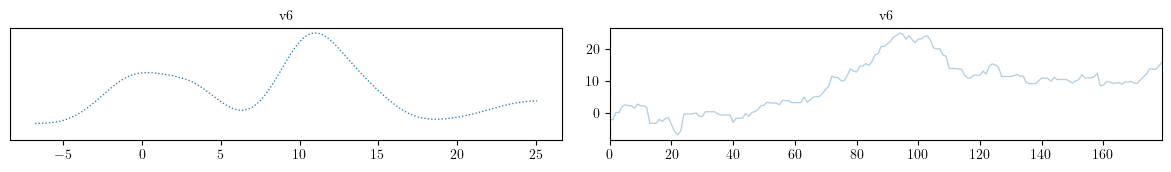

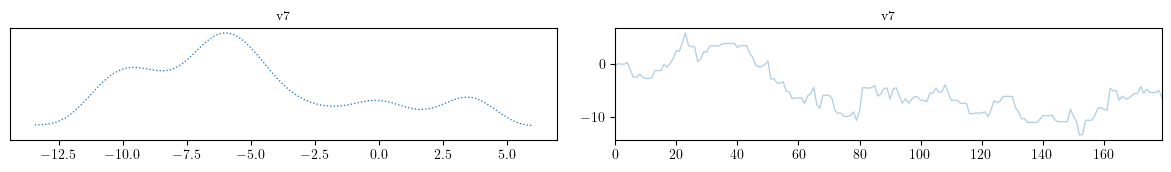

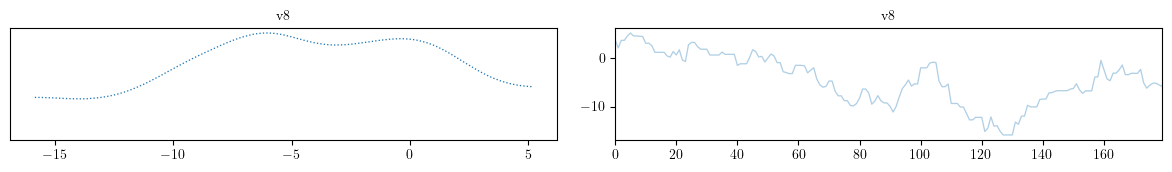

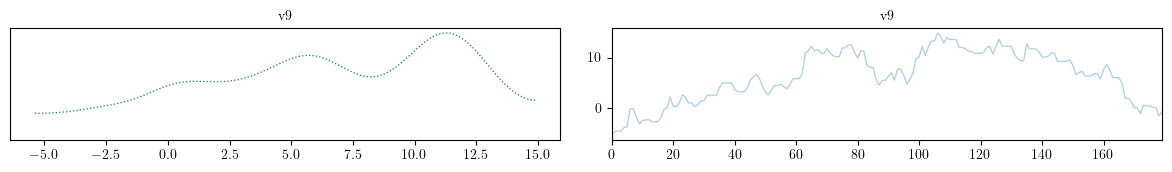

In [31]:
# define_plot_settings(10)
for i in range(N_KL):
    bt_samples_MH.plot_trace([i]);
# samples_NUTS.plot_trace([3])
# samples_MH.plot_autocorrelation()

Selecting 5 randomly chosen variables


array([[<Axes: ylabel='v2'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='v3'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='v5'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='v0', ylabel='v7'>, <Axes: xlabel='v2'>,
        <Axes: xlabel='v3'>, <Axes: xlabel='v5'>]], dtype=object)

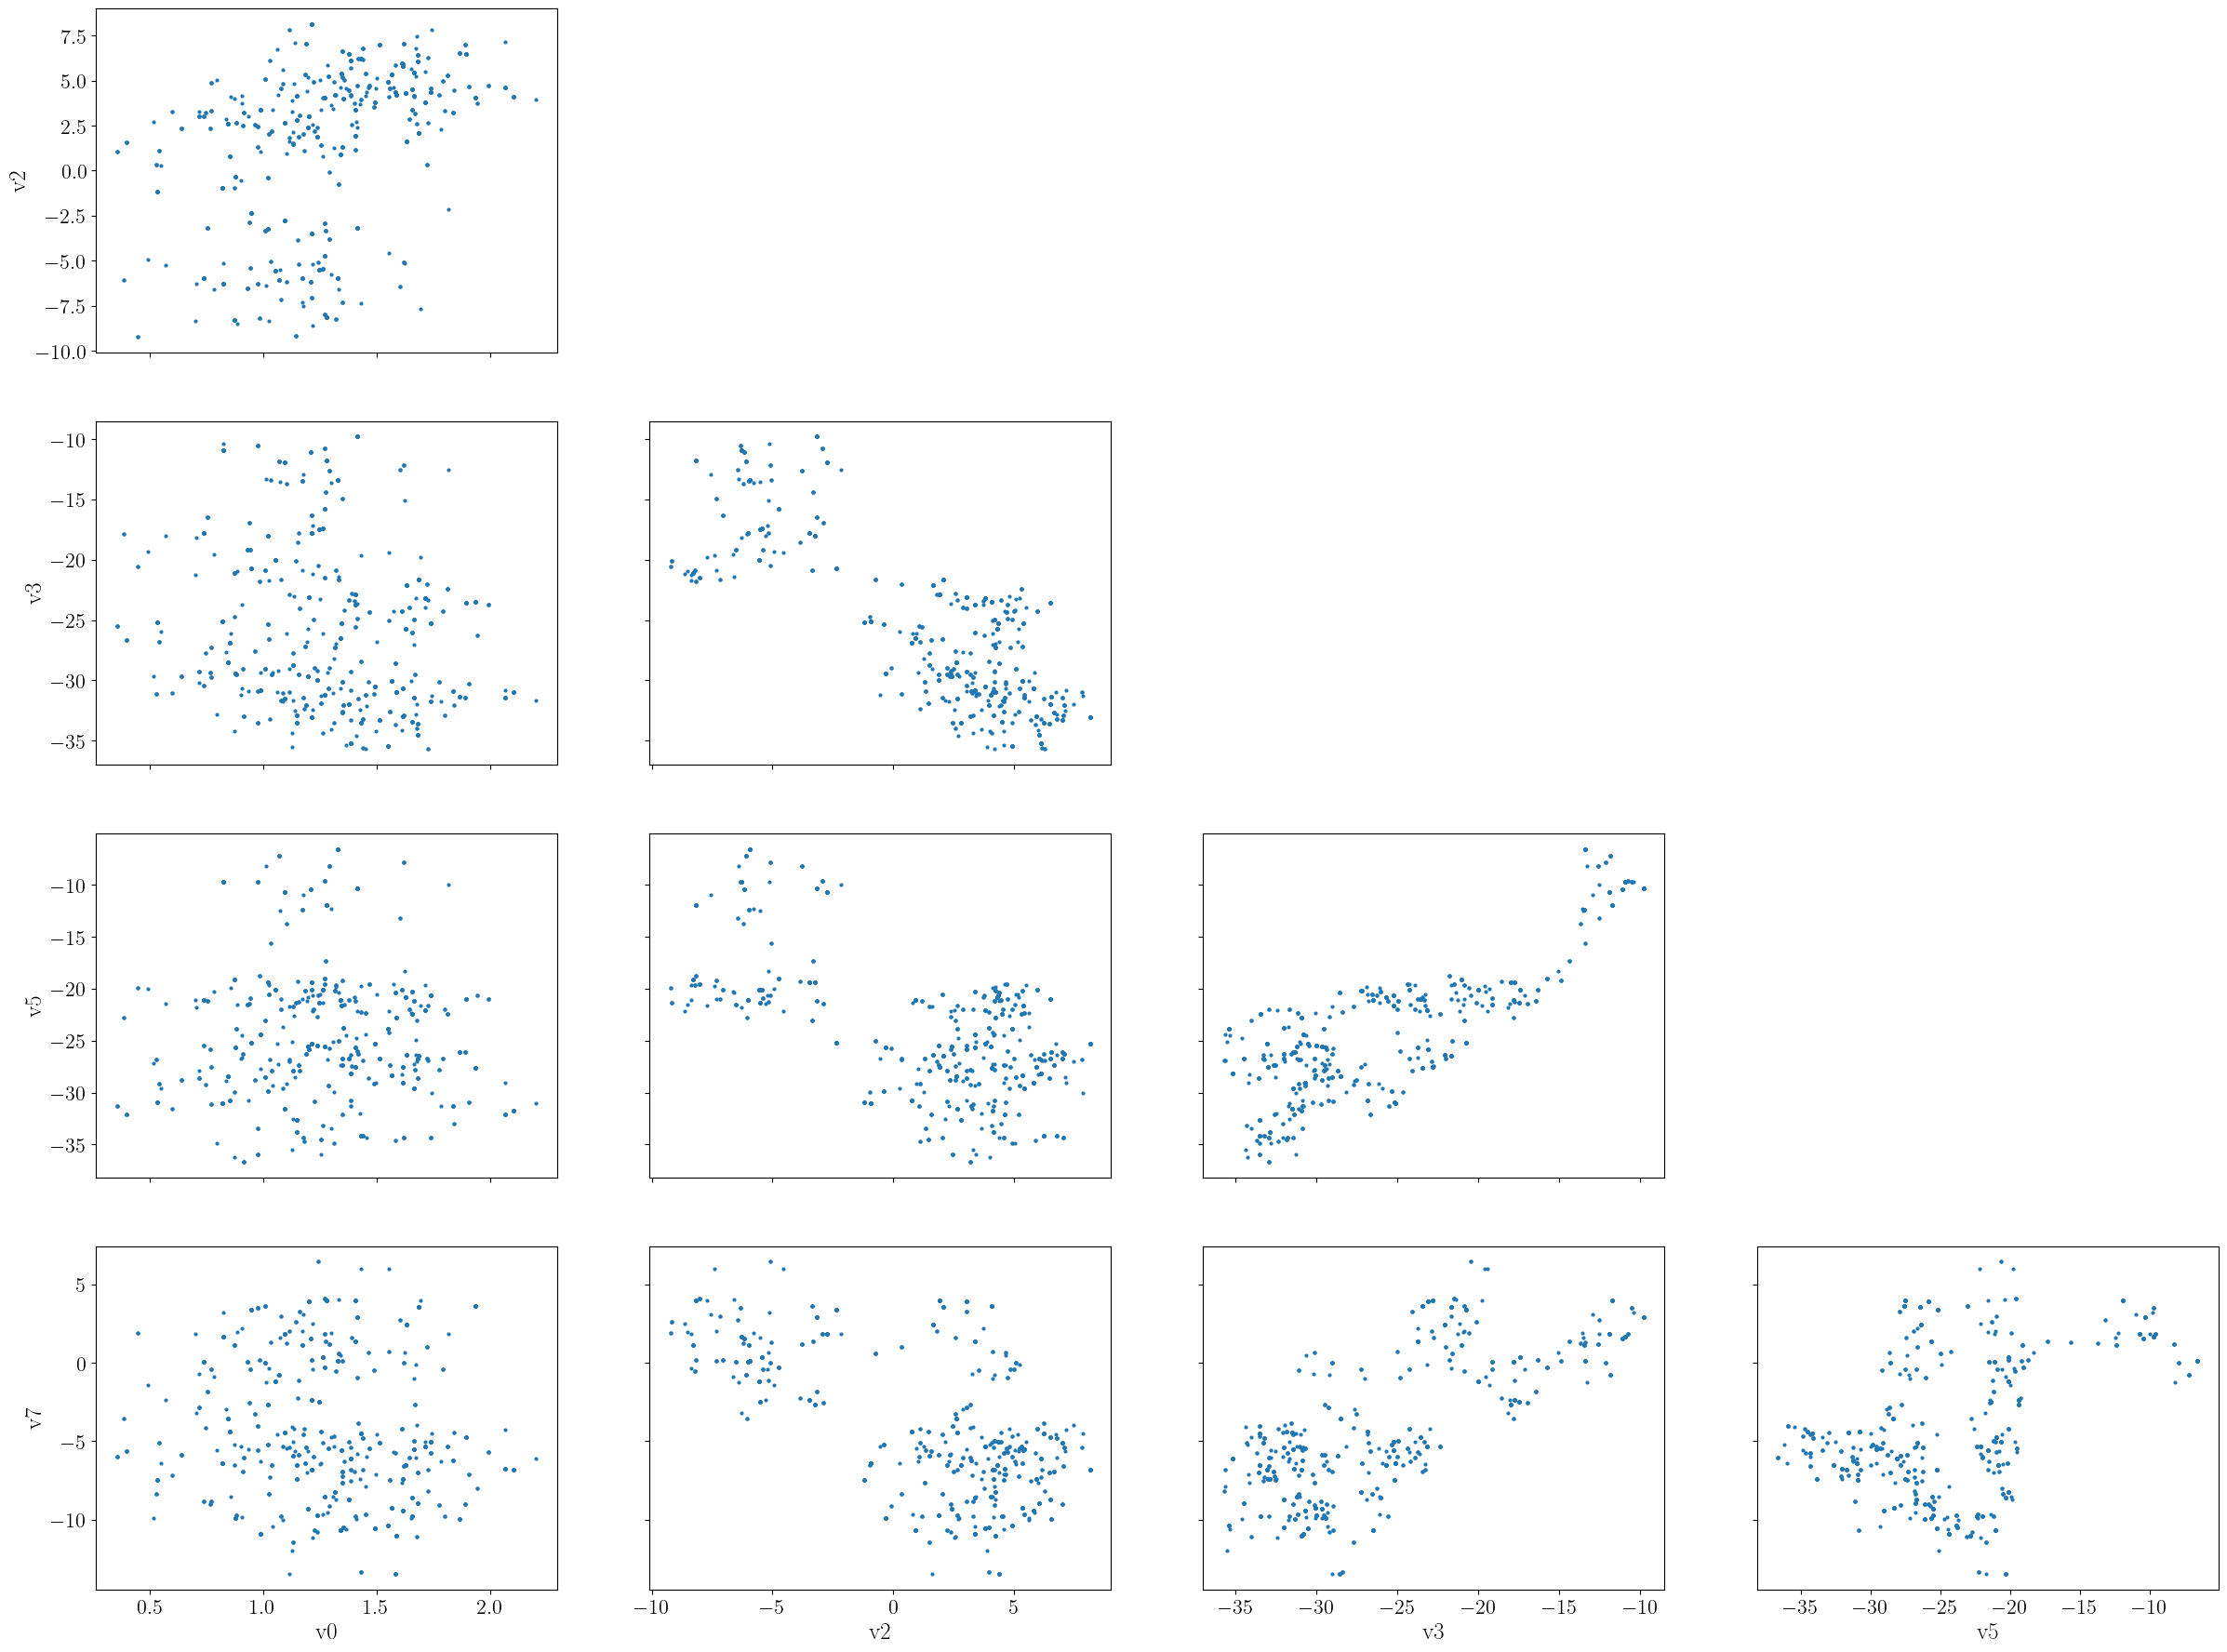

In [32]:
samples_MH.plot_pair()

In [33]:
sampler_NUTS.num_tree_node_list

NameError: name 'sampler_NUTS' is not defined

In [34]:
plt.plot(sampler_NUTS.num_tree_node_list)

NameError: name 'sampler_NUTS' is not defined

NameError: name 'samples_NUTS' is not defined

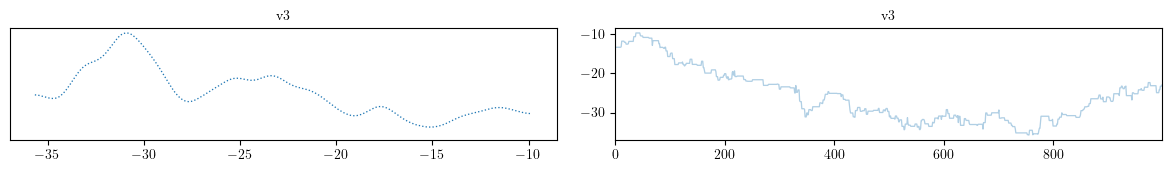

In [35]:
samples_MH.plot_trace([3])
samples_NUTS.plot_trace([3])

### Analytical model:

The relation between the beam deflection, $u$, and the external forces is given by the Euler-Bernoulli beam equation:

$$ M(v(\xi)) = -EI(\xi) \frac{d^2 v(\xi)}{d \xi^2}  $$

The bending stiffness of the beam is a product of the Young's modulus of the material, $E$, and the second moment of area, $I$. The second moment of area of a rectangular beam is related to the beam thickness by

$$ I_z = \frac{1}{12}bt^3 $$

The moment distribution for the tip load is found as 

$$ M(x) = -P(L - x) $$

Thus, the beam deflection can be found by solving the beam equation:

$$\frac{d^2 v(x)}{d x^2} =  \frac{P}{EI(x)}(L - x) $$
